In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/MyDrive


/content/gdrive/MyDrive


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import copy
import scipy.stats as st
import heapq
import pandas as pd
from collections import deque
from numpy.ma.core import zeros



below this the code for the classes and the simulation, output is a list with the following entries for each time an event takes place: timestamp, gate parking spot occupancy, gate parking spot occupancy size (looking at the size of each vehicle), gate queue length (nr of vehicles), station 1 parking spot occupancy, station 1 size, station 1 queue length, etc.

In [ ]:
import heapq


class FES:

    def __init__(self):
        self.events = []

    def add(self, event):
        heapq.heappush(self.events, event)

    def next(self):
        return heapq.heappop(self.events)

    def isEmpty(self):
        return len(self.events) == 0


In [ ]:
class Event:

    ARRIVAL = 0
    STATIONMOVE = 1
    DEPARTURE = 2
    IMPATIENT = 3

    def __init__(self, typ, vehicle, time):
        self.type = typ
        self.vehicle = vehicle
        self.time = time

    def __lt__(self, other): # due to events possibly taking place at the same time, also sort them by type
        if self.time == other.time:
            if self.type == self.IMPATIENT or other.type == self.IMPATIENT:
                if self.type == self.IMPATIENT and other.type == self.IMPATIENT:
                    return self.vehicle.arrTime < other.vehicle.arrTime
                return self.type == self.IMPATIENT

            if self.type == self.DEPARTURE or other.type == self.DEPARTURE:
                if self.type == self.DEPARTURE and other.type == self.DEPARTURE:
                    return self.vehicle.arrTime < other.vehicle.arrTime
                return self.type == self.DEPARTURE

            if self.type == self.ARRIVAL or other.type == self.ARRIVAL:
                return self.type == self.ARRIVAL

            if self.vehicle.currentStation == 0 or other.vehicle.currentStation == 0:
                if self.vehicle.currentStation == 0 and other.vehicle.currentStation == 0:
                    if self.vehicle.priority == other.vehicle.priority:
                        return self.vehicle.arrTime < other.vehicle.arrTime
                    return self.vehicle.priority < other.vehicle.priority
                return other.vehicle.currentStation == 0

            if self.vehicle.currentStation.order == other.vehicle.currentStation.order:
                return self.vehicle.arrTime < other.vehicle.arrTime
            return self.vehicle.currentStation.order > other.vehicle.currentStation.order

        return self.time < other.time


In [ ]:
import heapq
import copy


class Vehicle:

    def __init__(self, arrTime, stations, forgetCityPass, impatiencyTime, vehicleVars, typRNG):
        self.arrTime = arrTime
        self.forgetCityPass = forgetCityPass
        self.impatiencyTime = impatiencyTime
        self.gateWaitTime = 0
        self.stationArrTime = 0
        self.stationWaitTime = 0
        self.serviced = False
        self.stations = stations
        self.upcomingStations = copy.copy(stations)
        heapq.heapify(self.upcomingStations)
        self.currentStation = 0
        self.vehicleTypes = dict({})
        for i in range(len(vehicleVars)):
            self.vehicleTypes[list(vehicleVars.keys())[i]] = i
        self.type = 0
        self.typRNG = typRNG
        while self.typRNG > vehicleVars[list(vehicleVars.keys())[self.type]]:
            self.typRNG -= vehicleVars[list(vehicleVars.keys())[self.type]]
            self.type += 1
        if self.type == self.vehicleTypes["VAN"]:
            self.size = 2
        else:
            self.size = 1
        if self.type == self.vehicleTypes["PEDESTRIAN"] or self.type == self.vehicleTypes["BIKE"]:
            self.priority = 1
        else:
            self.priority = 2

    def setDepTime(self, depTime):
        self.depTime = depTime

    def nextStation(self):
        self.currentStation = heapq.heappop(self.upcomingStations)
        return self.currentStation

    def noStationsLeft(self):
        return len(self.upcomingStations) == 0

    def __lt__(self, other):
        if self.priority < other.priority:
            return True
        return self.arrTime <= other.arrTime


In [ ]:
import heapq


class GateQueue:

    def __init__(self):
        self.queue = []

    def add(self, vehicle):
        heapq.heappush(self.queue, vehicle)

    def next(self):
        return heapq.heappop(self.queue)

    def isEmpty(self):
        return len(self.queue) == 0

    def length(self):
        return len(self.queue)

    def remove(self, vehicle):
        self.queue.remove(vehicle)
        heapq.heapify(self.queue)

In [ ]:
from collections import deque
import numpy as np

rng = np.random.default_rng()


class Gate:

    def __init__(self, capacity, serviceTimeVars):
        self.capacity = capacity
        self.occupation = deque()
        self.queue = GateQueue()
        self.serviceTimeVars = serviceTimeVars

    def add(self, vehicle):
        if not self.isFull():
            self.occupation.append(vehicle)
        else:
            self.queue.add(vehicle)

    def queueToGate(self):
        vehicle = self.queue.next()
        self.occupation.append(vehicle)
        return vehicle

    def remove(self, vehicle):
        self.occupation.remove(vehicle)

    def isFull(self):
        return len(self.occupation) == self.capacity

    def fill(self):
        fill = 0
        for i in range(len(self.occupation)):
            fill += self.occupation[i].size
        return fill

    def relativeFill(self):
        return len(self.occupation) / self.capacity

    def returnQueueLen(self):
        return self.queue.length()

    def genServiceTime(self):
        serviceTime = rng.gamma(self.serviceTimeVars[0], self.serviceTimeVars[1])
        return serviceTime


In [ ]:
from collections import deque


class GarbageQueue:

    def __init__(self):
        self.queue = deque()

    def remove(self, vehicle):
        self.queue.remove(vehicle)

    def add(self, vehicle):
        self.queue.append(vehicle)

    def isEmpty(self):
        return len(self.queue) == 0

    def length(self):
        return len(self.queue)

In [ ]:
from collections import deque
import numpy as np

rng = np.random.default_rng()


class Station:

    def __init__(self, name, order, capacity, serviceTimeVars):
        self.name = name
        self.order = order
        self.capacity = capacity
        self.occupation = deque()
        self.queue = GarbageQueue()
        self.serviceTimeVars = serviceTimeVars

    def __lt__(self, other):
        return self.order < other.order

    def fill(self):
        fill = 0
        for i in range(len(self.occupation)):
            fill += self.occupation[i].size
        return fill

    def fits(self, size):
        return (self.capacity - self.fill()) >= size

    def add(self, vehicle):
        if self.fits(vehicle.size) and self.queue.isEmpty():
            self.occupation.append(vehicle)
        else:
            self.queue.add(vehicle)

    def queueFits(self):
        return self.fits(self.queue.queue[0].size)

    def queueToStation(self):
        vehicle = self.queue.queue[0]
        self.queue.remove(vehicle)
        self.occupation.append(vehicle)
        return vehicle

    def remove(self, vehicle):
        self.occupation.remove(vehicle)

    def isFull(self):
        return self.fill() == self.capacity

    def relativeFill(self):
        return self.fill() / self.capacity

    def returnQueueLen(self):
        return self.queue.length()

    def genServiceTime(self):
        serviceTime = rng.gamma(self.serviceTimeVars[0], self.serviceTimeVars[1])
        return serviceTime


In [ ]:
import numpy as np

rng = np.random.default_rng()


class Simulation:

    def simulate(self, startTime, openTime, closeTime, stations, arrTimeVars, gateTimeVars, impatiencyVars, vehicleVars, gateEntrances = 1, forgetChance = 0.05, disableImpatiency = False):
        t = startTime
        fes = FES()

        stationLst = []
        for n in range(len(stations)):
            stationLst.append(Station(stations[n][0], stations[n][1], stations[n][2], stations[n][3]))
        gate = Gate(gateEntrances, gateTimeVars)

        self.createArrival(t, startTime, closeTime, arrTimeVars, impatiencyVars, stationLst, stations, forgetChance, vehicleVars, fes)

        queueLog = []
        impatientLog = []
        vehicleLog = []
        self.logQueues(queueLog, t, gate, stationLst)

        run = True
        while run:
            event = fes.next()
            t = event.time
            vehicle = event.vehicle
            if event.type == Event.ARRIVAL:
                gate.add(vehicle)
                if gate.queue.isEmpty():
                    # plan move to station
                    self.planGateMove(t, openTime, vehicle, gate, fes)
                elif not disableImpatiency:
                    # plan leaving due to impatiency
                    event = Event(Event.IMPATIENT, vehicle, vehicle.impatiencyTime)
                    fes.add(event)
                # plan next arrival
                self.createArrival(t, startTime, closeTime, arrTimeVars, impatiencyVars, stationLst, stations, forgetChance, vehicleVars, fes)

            elif event.type == Event.STATIONMOVE:
                oldStation = vehicle.currentStation
                if oldStation == 0: # the old station was the gate
                    allSpace = True # check if all stations have space
                    for n in range(len(stationLst)):
                        if not stationLst[n].fits(vehicle.size):
                            allSpace = False
                    if allSpace:
                        newStation = vehicle.nextStation()
                        # move to next station
                        newStation.add(vehicle)
                        if newStation.queue.isEmpty():
                            # instantly serviced at new station
                            self.planStationMove(t, vehicle, newStation, fes)
                        # manage situation at old location (gate)
                        gate.remove(vehicle)
                        if not gate.queue.isEmpty():
                            newVehicle = gate.queueToGate()
                            self.planGateMove(t, openTime, newVehicle, gate, fes)
                    else: # no space for vehicle so reinsert this event directly after the next time someone moves from a station
                        nextEventType = Event.ARRIVAL
                        nextEventStation = 0
                        i = -1
                        while not ((nextEventType == Event.DEPARTURE or nextEventType == Event.STATIONMOVE) and not nextEventStation == 0):
                            i += 1
                            nextEventType = fes.events[i].type
                            nextEventStation = fes.events[i].vehicle.currentStation
                        event.time = fes.events[i].time
                        vehicle.gateWaitTime += event.time - t
                        fes.add(event)
                else:
                    newStation = vehicle.nextStation()
                    # move to next station
                    newStation.add(vehicle)
                    if newStation.queue.isEmpty():
                        # instantly serviced at new station
                        self.planStationMove(t, vehicle, newStation, fes)
                    # manage situation at old location (station)
                    self.updateOldStation(t, vehicle, oldStation, fes)

            elif event.type == Event.DEPARTURE:
                oldStation = vehicle.currentStation
                if oldStation == 0:
                    # manage situation at old location (gate)
                    gate.remove(vehicle)
                    if not gate.queue.isEmpty():
                        newVehicle = gate.queueToGate()
                        self.planGateMove(t, openTime, newVehicle, gate, fes)
                else:
                    # manage situation at old location (station)
                    self.updateOldStation(t, vehicle, oldStation, fes)
                self.logVehicle(vehicleLog, vehicle)

            elif event.type == Event.IMPATIENT and not vehicle.serviced:
                gate.queue.remove(vehicle)
                self.logImpatient(impatientLog, t, vehicle, gate)

            self.logQueues(queueLog, t, gate, stationLst)
            if fes.isEmpty():
                run = False
        return queueLog, impatientLog, vehicleLog

    def createArrival(self, t, startTime, closeTime, arrTimeVars, impatiencyVars, stationLst, stations, forgetChance, vehicleVars, fes):
        halfHourOfService = np.floor(t / 30 / 60) - np.floor(startTime / 30 / 60) # find correct vehicle arrival density
        beta = 1 / (arrTimeVars[int(halfHourOfService)] / 30 / 60)
        arrRNG = rng.exponential(scale = beta)
        emptyTimeslots = 0
        if arrRNG > 30 * 60 * (emptyTimeslots + 1): # with extremely sparse arrivals, a first arrival might take ages
            emptyTimeslots += 1                     # so it'll select the next density after half an hour
            beta = 1 / (arrTimeVars[int(halfHourOfService + emptyTimeslots)] / 30 / 60)
            arrRNG = emptyTimeslots * 30 * 60 + rng.exponential(scale=beta) / emptyTimeslots
        arrTime = t + arrRNG
        if arrTime <= closeTime: # as long as vehicles are allowed to arrive, create a new one
            impatiencyTime = arrTime + rng.gamma(impatiencyVars[0], impatiencyVars[1])
            typRNG = rng.uniform()
            vehicleStations = [] # generate stations to be visited and list cannot be empty
            while len(vehicleStations) == 0:
                for n in range(len(stationLst)):
                    if rng.uniform() <= stations[n][4]:
                        vehicleStations.append(stationLst[n])
            forgetCityPass = rng.uniform() <= forgetChance
            vehicle = Vehicle(arrTime, vehicleStations, forgetCityPass, impatiencyTime, vehicleVars, typRNG)
            event = Event(Event.ARRIVAL, vehicle, arrTime)
            fes.add(event)

    def planGateMove(self, t, openTime, vehicle, gate, fes):
        vehicle.gateWaitTime = t - vehicle.arrTime
        vehicle.serviced = True
        serviceTime = max(t, openTime) + gate.genServiceTime()
        if vehicle.forgetCityPass:
            vehicle.setDepTime(serviceTime)
            event = Event(Event.DEPARTURE, vehicle, serviceTime)
        else:
            vehicle.stationArrTime = serviceTime
            event = Event(Event.STATIONMOVE, vehicle, serviceTime)
        fes.add(event)

    def planStationMove(self, t, vehicle, station, fes):
        if vehicle.noStationsLeft():
            #plan departure
            serviceTime = t + station.genServiceTime()
            vehicle.setDepTime(serviceTime)
            event = Event(Event.DEPARTURE, vehicle, serviceTime)
            fes.add(event)
        else:
            #plan stationmove
            serviceTime = t + station.genServiceTime()
            vehicle.stationArrTime = serviceTime
            event = Event(Event.STATIONMOVE, vehicle, serviceTime)
            fes.add(event)

    def updateOldStation(self, t, vehicle, oldStation, fes):
        oldStation.remove(vehicle)
        if not oldStation.queue.isEmpty():
            if oldStation.queueFits():
                newVehicle = oldStation.queueToStation()
                newVehicle.stationWaitTime += (t - newVehicle.stationArrTime)
                self.planStationMove(t, newVehicle, oldStation, fes)

    def logQueues(self, log, t, gate, stationLst):
        logEntry = [t, len(gate.occupation), gate.fill(), gate.returnQueueLen()]
        for n in range(len(stationLst)):
            logEntry.append(len(stationLst[n].occupation))
            logEntry.append(stationLst[n].fill())
            logEntry.append(stationLst[n].returnQueueLen())
        log.append(logEntry)
        # print(logEntry)

    def logImpatient(self, log, t, vehicle, gate):
        logEntry = [t, vehicle.impatiencyTime - vehicle.arrTime, gate.returnQueueLen() + len(gate.occupation)]
        log.append(logEntry)

    def logVehicle(self, log, vehicle):
        logEntry = [vehicle.type, vehicle.arrTime, vehicle.depTime, vehicle.gateWaitTime, vehicle.stationWaitTime]
        if vehicle.forgetCityPass:
            subLogEntry = [0]
        else:
            subLogEntry = []
            for i in range(len(vehicle.stations)):
                subLogEntry.append(vehicle.stations[i].name)
        logEntry.append(subLogEntry)
        log.append(logEntry)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import datetime
import numpy as np

rng = np.random.default_rng()


def getData(fileNames): # enter data into arrays and extract the name of the sheets
    allData = []
    sheets = []
    for i in range(len(fileNames)):
        allData.append(pd.read_excel(fileNames[i], sheet_name=None))
        sheets.append(list(allData[i].keys()))
    return allData, sheets

def getArrivalCounts(arrivalTimes): # filter arrivals in 30 minute intervals
    arrTimes = convertTime(arrivalTimes)
    arrVars = []
    for i in range(24 * 2):
        subArrTimes = arrTimes[arrTimes >= i * 30 * 60]
        subArrTimes = subArrTimes[subArrTimes < (i + 1) * 30 * 60]
        arrVars.append(len(subArrTimes))
    return arrVars

def getArrVars(allData, sheets): # get arrival counts per 30 minute interval as well as first arrival/opening/closing time
    arrivals = []
    openTime = 24 * 60 * 60
    for i in range(len(allData)):
        arrivalTimes = allData[i][sheets[i][1]]['Arrival'].to_numpy(na_value=-1).tolist()
        while len(arrivalTimes) > 0 and arrivalTimes[0] == -1:
            arrivalTimes.remove(-1)
        if len(arrivalTimes) > 0:
            arrivals.append(getArrivalCounts(arrivalTimes))
        openTimes = allData[i][sheets[i][0]]['Arrival'].to_numpy(na_value=-1).tolist()
        openTimes = convertTime(openTimes)
        openTimeIndex = 0
        while openTimes[openTimeIndex] == -1:
            openTimeIndex += 1
        openTime = min(openTime, openTimes[openTimeIndex])
    openTime = np.floor(2 * openTime / 60 / 60) / 2
    arrivals = np.mean(arrivals, axis=0).tolist()
    startTime = 0
    while arrivals[0] == 0:
        startTime += 0.5
        del arrivals[0]
    closeTime = 24
    while arrivals[-1] == 0:
        closeTime -= 0.5
        del arrivals[-1]
    return arrivals, startTime, openTime, closeTime

def getGateServiceVars(allData, sheets): # get gate service times and match them to a gamma distribution
    gateServiceTimes = []
    for i in range(len(allData)):
        vehicleIDs = allData[i][sheets[i][2]]['Car ID'].to_numpy(na_value=-1).tolist()
        gateArrivalTimes = allData[i][sheets[i][2]]['Entrance Time'].to_numpy(na_value=-1).tolist()
        gateArrivalTimes = convertTime(gateArrivalTimes)
        gateDepTimes = [24 * 60 * 60] * len(gateArrivalTimes)
        for j in range(len(sheets[i][3:])):
            keys = allData[i][sheets[i][3 + j]].columns
            stationVehicleIDs = allData[i][sheets[i][3 + j]][keys[0]].to_numpy(na_value=-1).tolist()
            stationArrivalTimes = allData[i][sheets[i][3 + j]][keys[1]].to_numpy(na_value=-1).tolist()
            stationArrivalTimes = convertTime(stationArrivalTimes)
            for k in range(len(stationVehicleIDs)):
                if stationVehicleIDs[k] != -1 and stationVehicleIDs[k] != 'Mbike' and stationVehicleIDs[k] != 'Foot':
                    index = 0
                    search = True
                    while stationVehicleIDs[k] in vehicleIDs[index + 1:] and search:
                        index = vehicleIDs.index(stationVehicleIDs[k], index + 1)
                        if gateArrivalTimes[index] < stationArrivalTimes[k]:
                            gateDepTimes[index] = min(stationArrivalTimes[k], gateDepTimes[index])
                            search = False
                        else:
                            gateDepTimes[index] = 0
                            search = False
        for j in range(len(gateDepTimes)):
            delta = gateDepTimes[j] - gateArrivalTimes[j]
            if delta < 2 * 60 and delta > 0:
                gateServiceTimes.append(delta)
    theta = np.var(gateServiceTimes) / np.mean(gateServiceTimes)
    k = np.mean(gateServiceTimes) / theta
    # randomSamples = rng.gamma(k, theta, 2000)
    # plt.hist(gateServiceTimes, weights = [1/len(gateServiceTimes)] * len(gateServiceTimes), bins = 100)
    # plt.hist(randomSamples, bins=100, density=True, alpha=0.5)
    # plt.show()
    return (k, theta)

def getStationServiceVars(allData, sheets): # get servicetimes for each station and match them to gamma distributions
    stations = sheets[0][3:]
    stationServiceVars = dict({})
    for j in range(len(stations)):
        arrTimes = []
        depTimes = []
        for i in range(len(allData)):
            keys = allData[i][sheets[i][3 + j]].columns.tolist()
            arrTimes.extend(allData[i][sheets[i][3 + j]][keys[1]].to_numpy(na_value=-1).tolist())
            depTimes.extend(allData[i][sheets[i][3 + j]][keys[2]].to_numpy(na_value=-1).tolist())
        arrTimes = convertTime(arrTimes)
        depTimes = convertTime(depTimes)
        deltaTimes = np.zeros(len(arrTimes))
        k = 0
        for i in range(len(arrTimes)):
            if arrTimes[i] != -1 and depTimes[i] != -1 and arrTimes[i] < depTimes[i] and depTimes[i] - arrTimes[i] < 30 * 60:
                deltaTimes[k] = depTimes[i] - arrTimes[i]
                k += 1
        deltaTimes = deltaTimes[:-deltaTimes.tolist().count(0)]
        theta = np.var(deltaTimes) / np.mean(deltaTimes)
        k = np.mean(deltaTimes) / theta
        stationServiceVars[sheets[0][3 + j]] = [k, theta]
        # randomSamples = rng.gamma(k, theta, 2000)
        # plt.hist(deltaTimes, density=True, bins = 50)
        # plt.hist(randomSamples, bins=50, density=True, alpha=0.5)
        # plt.show()
    return stationServiceVars

def getGarbageAtStations(allData, sheets): # get the garbage collected at each station
    stations = sheets[0][3:]               # overwritten due to a mismatch between literature and the datasheets
    # stationGarbage = []
    # for j in range(len(stations)):
    #     stationGarbage.append(dict({}))
    #     for i in range(len(allData)):
    #         subStationGarbage = allData[i][sheets[i][3 + j]].columns[3:].tolist()
    #         for k in range(len(subStationGarbage)):
    #             if "Unnamed: " not in subStationGarbage[k] and "Service Time" not in subStationGarbage[k]:
    #                 if subStationGarbage[k] in stationGarbage[j]:
    #                     stationGarbage[j][subStationGarbage[k]] += 1/len(allData)
    #                 else:
    #                     stationGarbage[j][subStationGarbage[k]] = 1 / len(allData)
    #     keys = list(stationGarbage[j].keys())
    #     for i in keys:
    #         if stationGarbage[j][i] < 0.5:
    #             del stationGarbage[j][i]
    #     stationGarbage[j] = list(stationGarbage[j].keys())
    stationGarbage = [['T', 'Wc', 'Gr', 'Gs', 'E'], ['Dc', 'Dd', 'Gp', 'Ch'], ['F'], ['W', 'P', 'M'], ['Ca', 'Ma', 'Sl', 'A', 'R', 'Cl', 'B']]
    return stations, stationGarbage

def getGarbageTypeChance(allData, sheets): # get the chance each type of garbage is present
    mainSheetKeys = allData[0][sheets[0][0]].columns
    idIndex = mainSheetKeys[0]
    garbageTypes = mainSheetKeys[5:].tolist()
    garbageTypeChance = np.zeros(len(garbageTypes))
    nVehicles = 0
    for i in range(len(allData)):
        dataSheet = allData[i][sheets[i][0]]
        for j in range(len(dataSheet)):
            if not type(dataSheet[idIndex][j]) == float:
                nVehicles += 1
                for k in range(len(garbageTypes)):
                    if dataSheet[garbageTypes[k]][j] == 1 or dataSheet[garbageTypes[k]][j] == 0:
                        garbageTypeChance[k] += dataSheet[garbageTypes[k]][j]
    garbageTypeChance = garbageTypeChance / nVehicles
    garbageTypeChanceDict = dict({})
    for i in range(len(garbageTypes)):
        garbageTypeChanceDict[garbageTypes[i]] = garbageTypeChance[i]
    return garbageTypeChanceDict

def getForgetChance(allData, sheets): # finds 'pass' in the comments of the entrance sheet to see if anyone has forgotten their pass
    forgotten = 0
    nVehicles = 0
    for i in range(len(allData)):
        vehicles = allData[i][sheets[i][2]].to_numpy(na_value=-1)[:, 0].tolist()
        nVehicles += len(vehicles) - vehicles.count(-1)
        comments = allData[i][sheets[i][2]]['Comments']
        for j in range(len(comments)):
            if type(comments[j]) == str and 'pass' in comments[j]:
                forgotten += 1
    return forgotten / nVehicles

def getImpatiencyVars(allData, sheets): # tries to find variables for the gamma distribution of the times people are willing to wait in queue
    deltaTimes = []                     # it does this by trying to match it in a crude machine learning type of manner
    queueTimes = []
    for i in range(len(allData)):
        keys = allData[i][sheets[i][1]].columns
        arrTimes = allData[i][sheets[i][1]][keys[2]].to_numpy(na_value=-1).tolist()
        depTimes = allData[i][sheets[i][1]][keys[3]].to_numpy(na_value=-1).tolist()
        vehicleIDs = allData[i][sheets[i][1]][keys[0]].to_numpy(na_value=-1).tolist()
        keys = allData[i][sheets[i][2]].columns
        gateArrTimes = allData[i][sheets[i][2]][keys[2]].to_numpy(na_value=-1).tolist()
        gateVehicleIDs = allData[i][sheets[i][2]][keys[0]].to_numpy(na_value=-1).tolist()
        arrTimes = convertTime(arrTimes)
        depTimes = convertTime(depTimes)
        gateArrTimes = convertTime(gateArrTimes)
        for j in range(len(depTimes)):
            if depTimes[j] != -1 and arrTimes[j] != -1:
                deltaTimes.append(depTimes[j] - arrTimes[j])
            elif arrTimes[j] != -1 and vehicleIDs.count(vehicleIDs[j]) == 1 and gateVehicleIDs.count(vehicleIDs[j]) == 1:
                index = gateVehicleIDs.index(vehicleIDs[j])
                if gateArrTimes[index] != -1 and gateArrTimes[index] - arrTimes[j] > 0:
                    queueTimes.append(gateArrTimes[index] - arrTimes[j])
    attempts = 250
    lastImprovement = 0
    runs = 1
    maxRuns = 10000
    startScale = 5
    repeats = 10
    totalVehicles = len(queueTimes)
    totalImpatient = len(deltaTimes)
    oldTheta = np.var(deltaTimes) / np.mean(deltaTimes)
    oldK = np.mean(deltaTimes) / oldTheta
    oldErr = 0
    for i in range(repeats):
        randomSamples = rng.gamma(oldK, oldTheta, totalVehicles)
        for j in range(totalVehicles):
            if randomSamples[j] < queueTimes[j]:
                oldErr += 1
    oldErr = oldErr / repeats - totalImpatient
    while lastImprovement < attempts and runs < maxRuns:
        theta = max(oldTheta + rng.normal(scale = startScale/math.sqrt(runs)), 0)
        k = max(oldK + rng.normal(scale = startScale/math.sqrt(runs)), 0)
        err = 0
        for i in range(repeats):
            randomSamples = rng.gamma(k, theta, totalVehicles)
            for j in range(totalVehicles):
                if randomSamples[j] < queueTimes[j]:
                    err += 1
        err = err / repeats - totalImpatient
        if abs(err) < abs(oldErr):
            oldErr = err
            oldTheta = theta
            oldK = k
            lastImprovement = 0
        else:
            lastImprovement += 1
        runs += 1
    plt.hist(queueTimes)
    plt.show()
    # plt.hist(rng.gamma(oldK, oldTheta, 1000))
    # plt.show()
    # print(oldErr)
    return [oldK, oldTheta]

def getVehicleVars(allData, sheets): # get chances each type of vehicle shows up
    nVehicles = 0
    nVans = 0
    nFoot = 0
    nBike = 0
    for i in range(len(allData)):
        keys = allData[i][sheets[i][2]].columns
        vehicleIDs = allData[i][sheets[i][2]][keys[0]].to_numpy(na_value=-1).tolist()
        keys = allData[i][sheets[i][0]].columns
        sizes = allData[i][sheets[i][0]][keys[1]].to_numpy(na_value=-1).tolist()
        nVehicles += len(vehicleIDs) - vehicleIDs.count(-1)
        nVans += sizes.count('B')
        for j in range(len(vehicleIDs)):
            if type(vehicleIDs[j]) == str:
                if "FOT" in vehicleIDs[j] or "Foot" in vehicleIDs[j]:
                    nFoot += 1
                elif "BIK" in vehicleIDs[j] or "Bike" in vehicleIDs[j] or "Mbike" in vehicleIDs[j]:
                    nBike += 1
    nCars = nVehicles - nVans - nFoot - nBike
    varDict = dict({})
    varDict['VAN'] = nVans / nVehicles
    varDict['CAR'] = nCars / nVehicles
    varDict['PEDESTRIAN'] = nFoot / nVehicles
    varDict['BIKE'] = nBike / nVehicles
    return varDict

def convertTime(times): # convert times from the excel sheet into seconds since start of day
    convertedTime = np.zeros(len(times))
    for i in range(len(times)):
        if times[i] == -1:
            convertedTime[i] = -1
        elif type(times[i]) == float or type(times[i]) == int:
            timeStr = str(int(times[i]))
            convertedTime[i] = (int(timeStr[0:-4]) * 60 + int(timeStr[-4:-2])) * 60 + int(timeStr[-2:])
        elif type(times[i]) == datetime.time:
            convertedTime[i] = (times[i].hour * 60 + times[i].minute) * 60 + times[i].second
        elif type(times[i]) == str:
            if times[i].count(':') == 2:
                lIndex = times[i].find(':')
                rIndex = times[i].rfind(':')
                convertedTime[i] = (int(times[i][lIndex - 2:lIndex]) * 60 + int(times[i][lIndex + 1:rIndex])) * 60 + int(times[i][rIndex + 1:rIndex + 3])
            else:
                convertedTime[i] = -1
        else:
            print(times[i])
            print(type(times[i]))
    return convertedTime


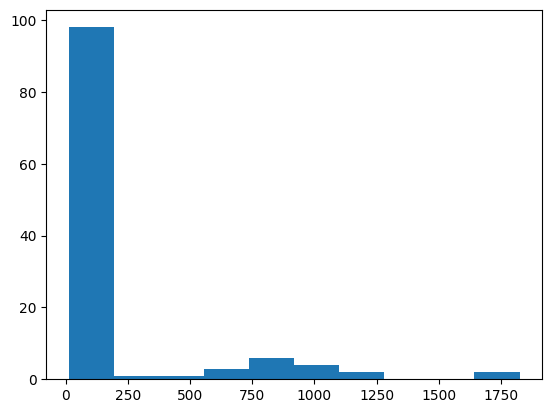

<ipython-input-17-dbf3258412df>:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vehicleLog = np.array(vehicleLog)


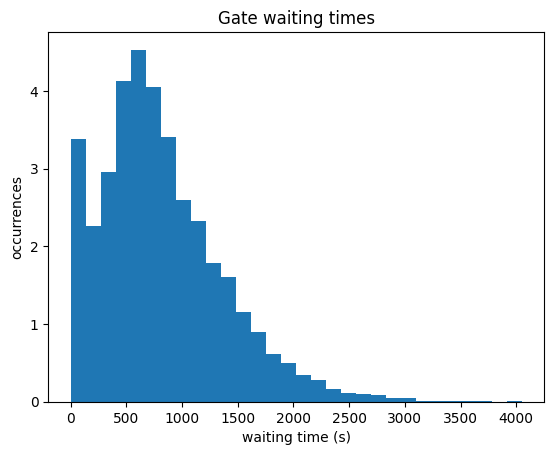

In 200 runs the mean time (s) when the gate queue is too long is 10823.418853171086 ± 1222.80256377635.
From an average of 135.375 ± 11.745823725903602 vehicles, an average of 97.95 ± 12.67112860008926 left the queue,
these had an average waiting time (s) of 645.9196009794591 ± 158.16136487491232. Vehicles usually spent 814.1980053707666 ± 553.1347993985556 seconds waiting at the gate
and 6.367748186032243 ± 49.596970769949415 seconds waiting at stations. They also spent an average of 850.172365261323 ± 660.8645204670183 seconds inside the WRP.


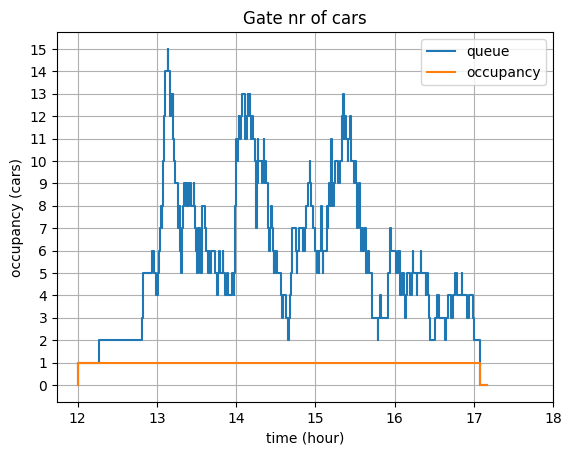

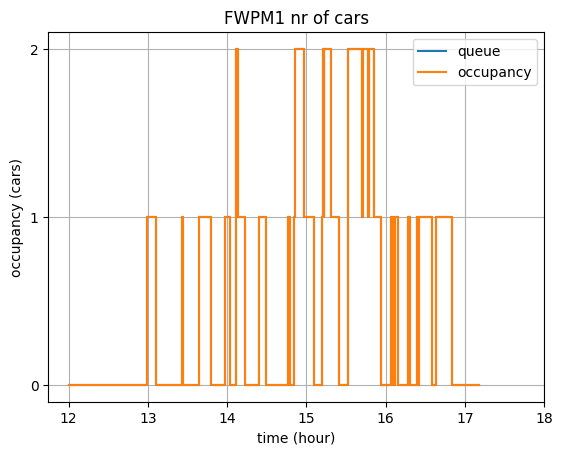

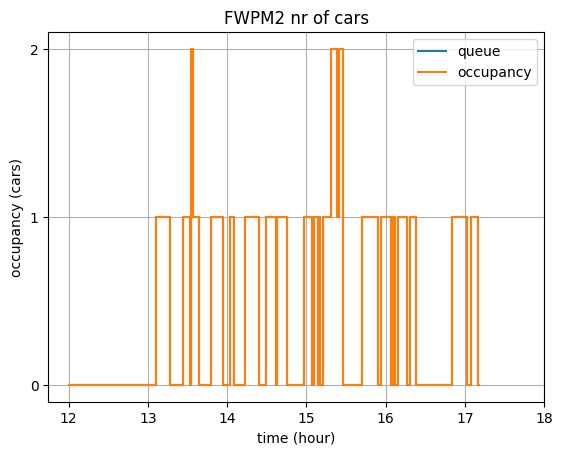

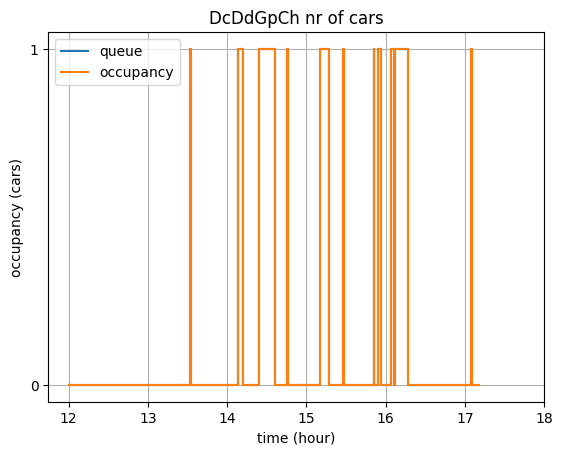

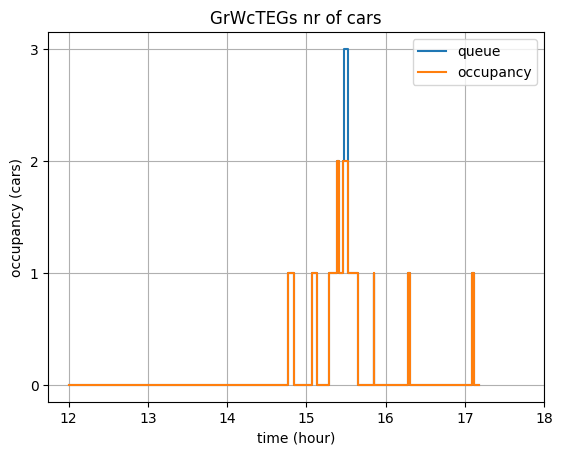

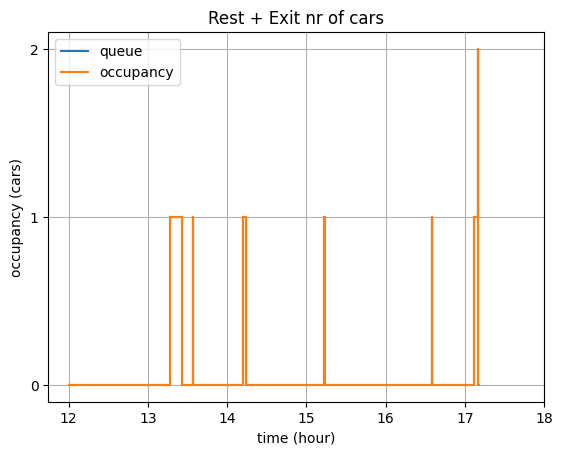

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def stepPlot(t, y, y2, title, yunit): # plot queue and occupancy over time
    plt.step(t, y + y2, label = 'queue')
    plt.step(t, y, label = 'occupancy')
    start = int(np.floor(min(t)))
    stop = int(np.ceil(max(t)))
    xValues = range(start, stop + 1, 1)
    plt.xticks(ticks = xValues, labels = xValues)
    yValues = range(0, int(max(y + y2) + 1), 1)
    plt.yticks(ticks = yValues, labels = yValues)
    plt.legend()
    plt.grid(True)
    plt.title(title)
    plt.xlabel('time (hour)')
    plt.ylabel('occupancy (' + yunit + ')')
    plt.show()

def histPlot(x, title, xlabel, ylabel, bins = 30, density = True, weights = None): # plot histogram
    plt.hist(x, bins = bins, density = density, log = False, weights = weights)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


# get all variables
fileNames = ['04-09-12RawData.xlsx', '06-09-12RawData.xlsx', '07-09-12RawData.xlsx']
allData, sheets = getData(fileNames)
arrivals, startTime, openTime, closeTime = getArrVars(allData, sheets)
garbageTypeChanceDict = getGarbageTypeChance(allData, sheets)
stations, stationGarbage = getGarbageAtStations(allData, sheets)
gateServiceVars = getGateServiceVars(allData, sheets)
vehicleVars = getVehicleVars(allData, sheets)
forgetChance = getForgetChance(allData, sheets)
stationServiceVars = getStationServiceVars(allData, sheets)
impatiencyVars = getImpatiencyVars(allData, sheets)

#setup simulation
sim = Simulation()

# set variables
gateTimeVars = gateServiceVars
startTime = startTime * 60 * 60
openTime = openTime * 60 * 60
closeTime = closeTime * 60 * 60
arrTimeVars = arrivals
forgetChance = forgetChance
impatiencyVars = impatiencyVars
vehicleVars = vehicleVars

# set stations
stationLst = []
stationOrder = ['FWPM1', 'FWPM2', 'DcDdGpCh', 'GrWcTEGs', 'Rest + Exit']
stationCapacity = [2, 2, 4, 3, 2]
for i in range(len(stationOrder)):
    stationIndex = stations.index(stationOrder[i])
    stationChance = 1
    for j in range(len(stationGarbage[stationIndex])):
        stationChance = stationChance * (1 - garbageTypeChanceDict[stationGarbage[stationIndex][j]])
    stationChance = 1 - stationChance
    stationLst.append([stationOrder[i], i + 1, stationCapacity[i], stationServiceVars[stationOrder[i]], stationChance])

# set number of gate entrances (they share the same queue)
gateEntrances = 1

# set up the repeated simulation for results
nRuns = 200
gateQueueLimit = 3
meanQueueLength = np.zeros((1 + len(stations), nRuns))
meanTimeQueueTooLong = np.zeros(nRuns)
nVehicles = np.zeros(nRuns)
impatientVehicles = np.zeros(nRuns)
impatientTimes = []
gateWaitingTimes = []
stationWaitingTimes = []
serviceTimes = []
for i in range(nRuns):
    queueLog, impatientLog, vehicleLog = sim.simulate(startTime, openTime, closeTime, stationLst, arrTimeVars, gateTimeVars, impatiencyVars, vehicleVars, gateEntrances = gateEntrances, forgetChance = forgetChance, disableImpatiency = False)
    # process data from simulation
    queueLog = np.array(queueLog)
    impatientLog = np.array(impatientLog)
    vehicleLog = np.array(vehicleLog)
    for j in range(len(queueLog) - 1):
        meanTimeQueueTooLong[i] += ((queueLog[j, 1] + queueLog[j, 3]) > gateQueueLimit + gateEntrances) * (queueLog[j + 1, 0] - queueLog[j, 0])
        for k in range(len(stations) + 1):
            meanQueueLength[k][i] += queueLog[j, 3 + k * 3] * (queueLog[j + 1, 0] - queueLog[j, 0]) / (queueLog[-1][0] - queueLog[0][0])
    impatientVehicles[i] = len(impatientLog)
    for j in range(len(impatientLog)):
        impatientTimes.append(impatientLog[j][1])
    nVehicles[i] = len(vehicleLog) + impatientVehicles[i]
    for j in range(len(vehicleLog)):
        gateWaitingTimes.append(vehicleLog[j][3])
        stationWaitingTimes.append(vehicleLog[j][4])
        serviceTimes.append(vehicleLog[j][2] - vehicleLog[j][3] - vehicleLog[j][1])

# generate outputs
histPlot(gateWaitingTimes, 'Gate waiting times', 'waiting time (s)', 'occurrences', density = False, weights = [1/ nRuns] * len(gateWaitingTimes))
output = 'In ' + str(nRuns) + ' runs the mean time (s) when the gate queue is too long is ' + str(np.mean(meanTimeQueueTooLong)) + ' ± ' + str(np.std(meanTimeQueueTooLong)) + '.\n'
output += 'From an average of ' + str(np.mean(nVehicles)) + ' ± ' + str(np.std(nVehicles)) + ' vehicles, an average of ' + str(np.mean(impatientVehicles)) + ' ± ' + str(np.std(impatientVehicles)) + ' left the queue,\n'
output += 'these had an average waiting time (s) of ' + str(np.mean(impatientTimes)) + ' ± ' + str(np.std(impatientTimes)) + '. Vehicles usually spent ' + str(np.mean(gateWaitingTimes)) + ' ± ' + str(np.std(gateWaitingTimes)) + ' seconds waiting at the gate\n'
output += 'and ' + str(np.mean(stationWaitingTimes)) + ' ± ' + str(np.std(stationWaitingTimes)) + ' seconds waiting at stations. They also spent an average of ' + str(np.mean(serviceTimes)) + ' ± ' + str(np.std(serviceTimes)) + ' seconds inside the WRP.'
print(output)

stepPlot(queueLog[:, 0] / 60 / 60, queueLog[:, 1], queueLog[:, 3], 'Gate nr of cars', 'cars')
# stepPlot(queueLog[:, 0] / 60 / 60, queueLog[:, 2], queueLog[:, 3], 'Gate vehicle sizes', 'size')
for n in range(len(stations)):
    stepPlot(queueLog[:, 0] / 60 / 60, queueLog[:, n * 3 + 4], queueLog[:, n * 3 + 6], stationOrder[n] + ' nr of cars', 'cars')
#     stepPlot(queueLog[:, 0] / 60 / 60, queueLog[:, n * 3 + 5], resqueueLog[:, n * 3 + 6], stations[n][0] + ' vehicle sizes', 'size')

